In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [21]:
import json
import pandas as pd
import numpy as np
import time

In [22]:
likes_path = "/content/drive/MyDrive/Tesi/easytour-likes-2022-03MAR-21.json"
schede_path = "/content/drive/MyDrive/Tesi/easytour-schede-2022-03MAR-21.json"
data_path = "/content/drive/MyDrive/Tesi/data.csv"

In [23]:
df_schede = pd.read_json(schede_path)
df_likes = pd.read_json(likes_path)
data = pd.read_csv(data_path)  

In [24]:
df_schede_fields = df_schede[["id","userId", "title", "description", "duration", "datePublishing", "creationDate", "counterUseful", "categories", "viewCounter"]]
df_likes_ids = df_likes[["id", "userId"]]

In [25]:
data

,id,userId,title,description,duration,datePublishing,creationDate,counterUseful,viewCounter,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,62355f98272ae5672fbc3ac7,632,['spiaggia'],"['paradiso', 'amant', 'sole', 'mare', 'sole', ...",0.0,2022-03-19T04:44:09.503Z,2022-03-19T04:44:08.000+00:00,0,2.0,0,0,0,0,0,1,0.0,9
1,620abb33ff8ae67f37cafe3c,442,[],"['spiaggia', 'isola', 'spiaggia', 'mare', 'ter...",3600000.0,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,0,413.0,0,0,0,0,0,1,60.0,41
2,620aa536ff8ae67f37cafb06,442,['tigr'],"['marcio', 'maltrattamento', 'animal', 'sconsi...",3600000.0,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,0,414.0,0,0,0,0,0,1,60.0,41
3,62349ff2272ae5672fbc3135,632,['big'],"['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,0,4.0,0,0,0,0,0,1,0.0,10
4,6234aa65272ae5672fbc34c2,632,"['wat', 'tempio']","['spiaggia', 'pena', 'tempio', 'big', 'tempio'...",0.0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,0,4.0,0,0,0,0,0,1,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351,61f57f62306802033034ceed,536,"['avventura', 'cascata']","['esperienza', 'step', 'contatto', 'realtà', '...",259200000.0,2022-01-29T17:54:42.761Z,2022-01-29T17:54:42.000+00:00,0,42.0,0,0,0,0,0,1,4320.0,57
4352,61f668fa306802033034d239,536,['avventura'],"['spalla', 'esperienza', 'lascito', 'vista', '...",57600000.0,2022-01-30T10:31:22.977Z,2022-01-30T10:31:22.000+00:00,0,35.0,0,0,0,0,0,1,960.0,57
4353,620bbf26b1675d6cc11232f8,431,"['loma', 'polmon']","['mese', 'sole', 'capital', 'nuvola', 'nebbia'...",9000000.0,2022-02-15T14:56:39.554Z,2022-02-15T14:56:38.000+00:00,1,37.0,0,0,0,0,0,1,150.0,41
4354,61f3c6add91e9928f6e0922a,431,['lima'],"['angolo', 'turista', 'calor', 'gent', 'bellez...",172800000.0,2022-02-01T16:57:01.557Z,2022-01-28T10:34:21.000+00:00,1,51.0,0,0,0,0,0,1,2880.0,59


# Tf-Idf

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=False)
# description and title are put together
text = data['description'] + data['title']
tfidf_schede = tfidf_vectorizer.fit_transform((text))
tfidf_schede

<4356x17749 sparse matrix of type '<class 'numpy.float64'>'
	with 203045 stored elements in Compressed Sparse Row format>

In [27]:
df_tfidf = pd.DataFrame(tfidf_schede.toarray(), columns=tfidf_vectorizer.get_feature_names())
#print(df_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Embeddings

## Word2Vec

## Transformers

# Recommender systems

## **Method \#1**

**Method #1:** Recommend posts that are similar to the ones that the user liked -> use cosine similarity on tf-idf

In [ ]:
df_likes_ids.userId.drop_duplicates().isin(data.userId.drop_duplicates())

0        True
1        True
3        True
5        True
6       False
        ...  
1338    False
1425     True
1458    False
1459    False
1468    False
Name: userId, Length: 116, dtype: bool

In [ ]:
#list of user
users = pd.concat([df_likes_ids.userId, data.userId]).drop_duplicates() #some ids in likes are not in posts -> some users liked posts but not posted one
#list of posts' id
posts = data.id
#list of users and posts they liked
users_likes = df_likes_ids.groupby("userId").id.apply(list)
users_likes

userId
114    [61447a3224c29e59fe4c06ab, 61824f5f21889d3548f...
119    [6172da4472b6f336088b932b, 6218ec9f29ef4a75805...
129    [615acf21eb3bf47494b8e64b, 61aa039788b2e606829...
149    [61faf5d953a6a72116188d5b, 61f41fe330680203303...
150    [61b72f34e364b82f2ac8c88c, 61f3c801d91e9928f6e...
                             ...                        
630    [62215a990a0ebd53f7469748, 62174fea99163528c06...
632                           [6229df13aeb26768dc408e81]
637    [6212993a4f9d177c90f3830f, 6224bdb835684f072b2...
639                           [620a39a4e7ce7d5992612316]
640    [622aeada99fd4c40442f3082, 6217ab40ae6735171d5...
Name: id, Length: 116, dtype: object

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_schede, tfidf_schede)

In [ ]:
def get_recommendations(user_id: int):
    # Get the index of the user that we want to recommend posts to
    user_id_idx = df_schede[df_schede == user_id].index[0]
    # Get the pairwise similarity scores of all posts with that user
    sim_scores = list(enumerate(cosine_sim[user_id_idx]))
    # Sort the posts based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 5 most similar posts
    sim_scores = sim_scores[1:6]
    # Get the blog post ids
    post_ids = [i[0] for i in sim_scores]
    # Return the blog posts
    return df_schede.iloc[post_ids]

def print_recommendations(recommended_posts):
    for i in range(len(recommended_posts)):
        print("Post #" + str(i+1) + ":")
        print("Post ID: " + str(recommended_posts.iloc[i].id))
        print("Title: " + str(recommended_posts.iloc[i].title))
        print("Description: " + str(recommended_posts.iloc[i].description))
        print("\n")

In [ ]:
id = 632
#print("Posts that user {} liked:".format(id))
liked_posts = df_likes_ids[df_likes_ids["userId"] == id]
#print(liked_posts)
print("Posts:")
for _,p in liked_posts.iterrows():
    post = df_schede[df_schede["id"]== p["id"]]
    if not post.description.empty:
        print(post.title)
        print("-"*100)

Posts:
92    Bemo - immergiti nella vita locale indonesiana
Name: title, dtype: object
----------------------------------------------------------------------------------------------------


In [ ]:
recommended_posts = get_recommendations(id)
print_recommendations(recommended_posts)

Post #1:
Post ID: 61f6ce0b306802033034e3e7
Title: Le spiagge più belle della Sardegna
Description: La Sardegna è una regione ricca di spiagge meravigliose e mare dal colore cristallino, cercheremo di aiutarvi a trovare le spiagge più belle e quelle che secondo noi non potete assolutamente perdervi se fate un viaggio in questa regione fantastica!

📌Berchida
Berchida è una delle spiagge più lunghe e spaziosi della Sardegna. La Spiaggia è posizionata poco sopra il Golfo di Orosei ed è quasi tutta di sabbia finissima, inoltre, riesce a sorprenderti per i colori della sua acqua, davvero cristallina. La grandezza della spiaggia gioca a favore anche per la possibilità di avere un po’ di privacy e relax.

📌Spiaggia di S’archittu
Questa spiaggia è situata nella parte ovest della Sardegna poco sopra Oristano. La spiaggia in sé non è molto grande quindi vi consigliamo di arrivare presto per trovare posto. La particolarità è la presenza di un arco, appunto Archittu, formato dalla scogliera che rac

## **Method \#2**

**Method #2:** Given a user, shown him the posts that are more similar to the ones he wrote 

In [28]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline 

In [29]:
#list of user
users = pd.concat([df_likes_ids.userId, data.userId]).drop_duplicates()
#list of posts' id
posts = data.id
#list of users and posts they made
users_posts = data.groupby("userId").id.apply(list)
users_posts

userId
77     [6154833edee05f1877c59be1, 615c2b85eb3bf47494b...
119    [60f6d6864250196f9f64270c, 60f6d2f54250196f9f6...
129    [61408190533f2f326b89392b, 6140834d533f2f326b8...
149    [6190e32f068a0f468cc78c24, 620fd14f4f9d177c90f...
150    [61c9f24721c95d5d9109316d, 62263e1161e055356b8...
                             ...                        
632    [62355f98272ae5672fbc3ac7, 62349ff2272ae5672fb...
633                           [621cf9fc2fd07a48dd9f139d]
637    [621fe10a82ed1d1eef3a495c, 6228ffd7aeb26768dc4...
640    [622f6e2d46ef2b6d71a8deb7, 622b7950c992ca28f33...
642                           [623318fe0e1ee15c013192a1]
Name: id, Length: 142, dtype: object

In [30]:
X = pd.concat([data, df_tfidf], axis=1)

In [31]:
data_with_ids = X.drop(columns=["datePublishing", "creationDate", "duration", "description", "title"])

In [32]:
X.drop(columns=["id", "userId", "datePublishing", "creationDate", "duration", "description", "title"], inplace=True)

### How many clusters?

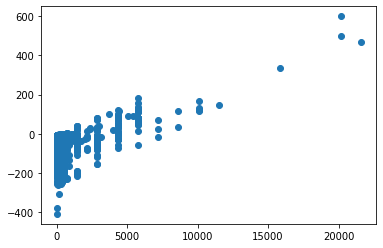

In [13]:
#Plot daata using SVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd = svd.fit_transform(X)
plt.scatter(svd[:,0], svd[:,1])
plt.show()

In [14]:
#Plot results
def plotKMeans(label, df):
  u_labels = np.unique(label)
  for i in u_labels:
      plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
  plt.title('K-means with {} clusters'.format(len(u_labels)))
  plt.legend()
  plt.show()

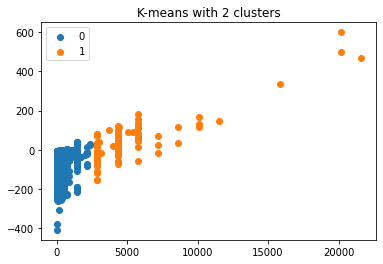

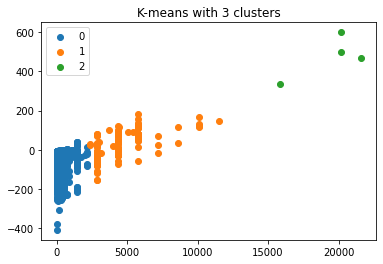

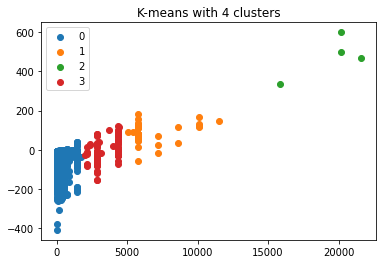

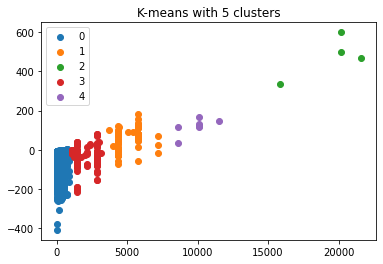

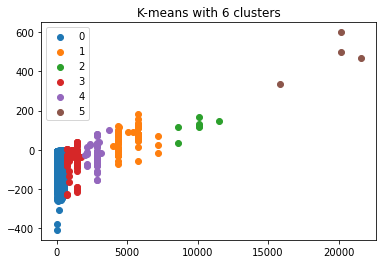

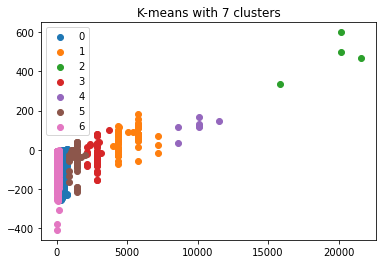

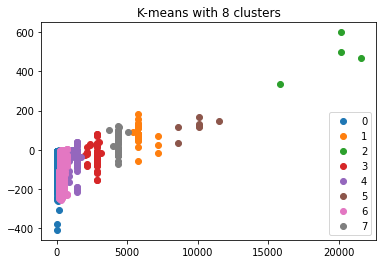

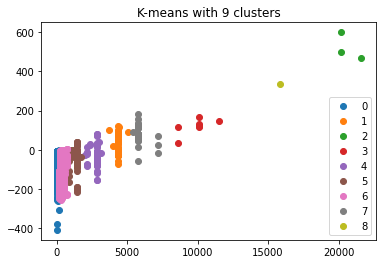

In [15]:
inertia = []
times = dict() #{k:time_needed}
K = range(2,10,1) #from 2 to 50 with step of 5
for k in K:
    #Fit 
    start = time.time()
    kmeanModel = KMeans(n_clusters=k)
    kmeans = kmeanModel.fit(X)
    time_needed = time.time() - start
    times[k] = time_needed
    #Elbow
    inertia.append(kmeanModel.inertia_)
    #Clusters
    label = kmeans.predict(X)
    plotKMeans(label, svd)

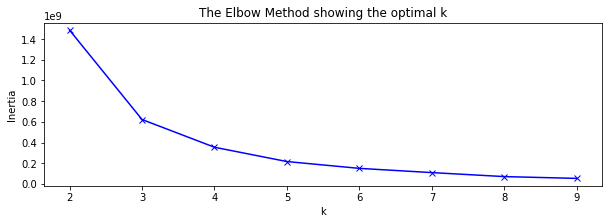

In [16]:
#Elbow
plt.figure(figsize=(10,3))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [17]:
#print(inertia)
for k,value in zip(K, inertia):
  print("Inertia for {} clusters is: {}".format(k,value))

Inertia for 2 clusters is: 1486001939.8605075
Inertia for 3 clusters is: 622562325.5048473
Inertia for 4 clusters is: 354627826.5123999
Inertia for 5 clusters is: 216438868.84854516
Inertia for 6 clusters is: 150627530.2014159
Inertia for 7 clusters is: 109822967.64314808
Inertia for 8 clusters is: 71207582.21933302
Inertia for 9 clusters is: 53926628.56294076


In [18]:
#print(times)
for k,v in times.items():
  print("Time needed to fit kmeans with {} clusters is: {}".format(k,v))

Time needed to fit kmeans with 2 clusters is: 7.435139179229736
Time needed to fit kmeans with 3 clusters is: 9.347939014434814
Time needed to fit kmeans with 4 clusters is: 11.653063774108887
Time needed to fit kmeans with 5 clusters is: 12.500734806060791
Time needed to fit kmeans with 6 clusters is: 18.355401754379272
Time needed to fit kmeans with 7 clusters is: 22.578028440475464
Time needed to fit kmeans with 8 clusters is: 28.081982135772705
Time needed to fit kmeans with 9 clusters is: 28.085889101028442


### Cluster Consenus

In [60]:
kmeanModel = KMeans(n_clusters=3)
kmeans = kmeanModel.fit(X.values)

In [61]:
p = kmeans.predict([X.iloc[0]])
print(p)

[0]


In [64]:
# compute distribution of the posts in the clusters for each user
# partitions = {user1: {c0:[post1, post4], c1:[post6], c2:[post3]}, user2:{c0:[], c1:[]}, etc}
def posts_in_partition():
  partitions = dict()
  for index, row in data.iterrows():
    userId = row["userId"]
    cluster = kmeans.predict([X.iloc[index]])
    if userId in partitions:
      if cluster[0] in partitions[userId]:
        partitions[userId][cluster[0]].append(row["id"])
      else:
        partitions[userId][cluster[0]] = [row["id"]]
    else:
      partitions[userId] = {}
      partitions[userId][cluster[0]] = [row["id"]]
  return partitions

In [65]:
partitions_by_user = posts_in_partition()

In [85]:
import heapq
def get_similarity(t):
  return t[0]

def similarity(target_user, top=5):
  # Creating empty heap
  heap = []
  heapq.heapify(heap)
  # number of target_user's posts in each cluster and total number of target's post
  if target_user not in partitions_by_user:
    print("Id not valid!")
    return
  target_partitions = partitions_by_user[target_user]
  target_scores = [len(x) for x in target_partitions.values()]
  number_posts_target = sum(target_scores)
  for k,v in partitions_by_user.items():
    if k == target_user:
      continue
    user_scores = [len(x) for x in v.values()]
    distance = sum([abs(x-y) for x,y in zip(target_scores, user_scores)])
    number_posts_user = sum(user_scores)
    total_posts = number_posts_target + number_posts_user
    similarity = 1 - (distance/total_posts)
    heapq.heappush(heap, (similarity, k))
  return heapq.nlargest(top, heap, key=get_similarity) 


In [86]:
id = 77
best_users = similarity(id)
best_users

[(1.0, 562), (1.0, 215), (1.0, 637), (1.0, 619), (1.0, 157)]